In [1]:
import awkward as ak
import os
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import warnings
import matplotlib.pyplot as plt
import numpy as np
import hist
import json

In [2]:
qcd = {}
path = '/project01/ndcms/cmoore24/skims/gluon_finding/mc'
for i in os.listdir(path):
    if 'qcd' in i:
        qcd_sample = ak.from_parquet(f'{path}/{i}/*')
        qcd_sample['GenJetAK8'] = qcd_sample.GenJetAK8[qcd_sample.goodjets.genJetAK8Idx]
        qcd_sample['goodjets', 'isGluon'] = (qcd_sample.GenJetAK8.partonFlavour == 21)

        # qcd_sample["goodjets"] = qcd_sample.goodjets[qcd_sample.goodjets.btag_count == 0]
        # mask = ~ak.is_none(ak.firsts(qcd_sample.goodjets))
        # qcd_sample = qcd_sample[mask]
              
        qcd[i] = qcd_sample

In [3]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)

In [4]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [5]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [6]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [7]:
def make_scaled_hist(group, prefix, var_name, range_down, range_up, bins=40, which_index=None, absv=False):
    hists = {}
    for i in group:
        new_hist = hist.Hist.new.Reg(bins, range_down, range_up, 
                                     name='variable', label=var_name).Weight()
        if which_index==None:
            to_fill = group[i][prefix][var_name]
        else:
            to_fill = group[i][prefix][var_name][:,which_index]
        if absv:
            to_fill = abs(to_fill)
        new_hist.fill(variable=to_fill)
        hists[i] = new_hist
        
    for i in hists:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
        hists[i].view(flow=True)[:] *= scale

    sum_hist = sum([hists[i] for i in hists])

    return sum_hist

In [33]:
hard_per = {}
mid_per = {}
soft_per = {}

hard_counts = {}
mid_counts = {}
soft_counts = {}
for j in range(500, 1450, 50):
    upper = j
    qcd_600 = {}
    for i in qcd:
            sample_goodjets = qcd[i].goodjets[(qcd[i].goodjets.pt >= 450)
                                                            & (qcd[i].goodjets.pt <= upper)] 
            mask = ~ak.is_none(ak.firsts(sample_goodjets))
            qcd_sample = qcd[i][mask]
    
            qcd_sample = qcd_sample[ak.num(qcd_sample.goodjets) >=3]
    
            qcd_600[i] = qcd_sample
        
    qcd_softcounts = make_scaled_hist(qcd_600, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 2, absv=True)
    qcd_midcounts = make_scaled_hist(qcd_600, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 1, absv=True)
    qcd_leadcounts = make_scaled_hist(qcd_600, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 0, absv=True)

    soft_per[str(upper)] = sum(qcd_softcounts[20:].values()) / (sum(qcd_softcounts[:].values()))
    mid_per[str(upper)] = sum(qcd_midcounts[20:].values()) / (sum(qcd_midcounts[:].values()))
    hard_per[str(upper)] = sum(qcd_leadcounts[20:].values()) / (sum(qcd_leadcounts[:].values()))

    soft_counts[str(upper)] = sum(qcd_softcounts[:].values())
    mid_counts[str(upper)] = sum(qcd_midcounts[:].values())
    hard_counts[str(upper)] = sum(qcd_leadcounts[:].values())

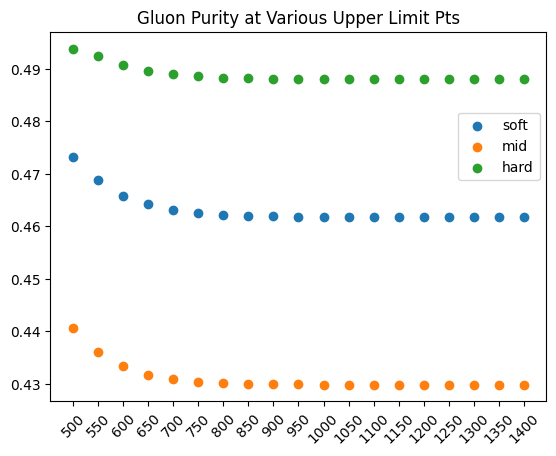

In [34]:
plt.scatter(x=list(soft_per.keys()), y=list(soft_per.values()), label='soft')
plt.scatter(x=list(mid_per.keys()), y=list(mid_per.values()), label='mid')
plt.scatter(x=list(hard_per.keys()), y=list(hard_per.values()), label='hard')
plt.legend(bbox_to_anchor=(1,0.8))
plt.title('Gluon Purity at Various Upper Limit Pts')
plt.xticks(rotation=45)
plt.show()

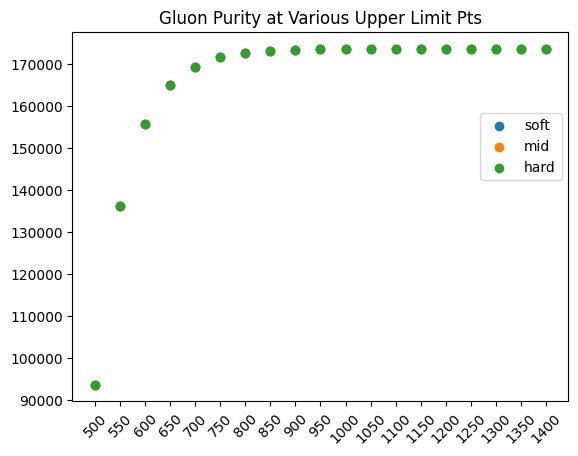

In [35]:
plt.scatter(x=list(soft_counts.keys()), y=list(soft_counts.values()), label='soft')
plt.scatter(x=list(mid_counts.keys()), y=list(mid_counts.values()), label='mid')
plt.scatter(x=list(hard_counts.keys()), y=list(hard_counts.values()), label='hard')
plt.legend(bbox_to_anchor=(1,0.8))
plt.title('Gluon Purity at Various Upper Limit Pts')
plt.xticks(rotation=45)
plt.show()

In [27]:
hard_per

{'750': 0.48305780691086,
 '800': 0.48691393750362577,
 '850': 0.4894657673356763,
 '900': 0.491626272972109,
 '950': 0.49313600436720706,
 '1000': 0.49354486931170993,
 '1050': 0.49272921594626534,
 '1100': 0.49162356347358144,
 '1150': 0.49040453848452004,
 '1200': 0.4894111979831744,
 '1250': 0.4888585267488514,
 '1300': 0.48816327200334175,
 '1350': 0.4878199808283479,
 '1400': 0.4875596229227131}